In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pymc3 as pm
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import theano.tensor as tt

In [2]:
cs = pd.read_csv("../data/chemical_shifts_theo_exp.csv")
cs_exp = cs['exp']
az.plot_kde(cs_exp)
plt.hist(cs_exp, density = True, bins = 30, alpha = 0.3)
plt.yticks([]);

In [3]:
cs.head(2)

ID   aa   theo    exp
0  1BM8  ILE  61.18  58.27
1  1BM8  TYR  56.95  56.18

# Categorical distribution

In [4]:
# very slow, very bad. 
clusters = 2
with pm.Model() as model_kg:
    p = pm.Dirichlet('p', a = np.ones(clusters)) #uniform
    z = pm.Categorical('z', p = p, shape = len(cs_exp))
    means = pm.Normal('means', mu = cs_exp.mean(), 
                     sd = 10, shape = clusters)
    sd = pm.HalfNormal('sd', sd = 10)
    
    y = pm.Normal('y', mu = means[z], sd = sd, observed = cs_exp)
    trace_kg = pm.sample(2000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sd, means, p]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1256 seconds.
C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The acceptance probability does not match the target. It is 0.8795346934569692, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [5]:
# reparameterized
clusters = 2 
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a = np.ones(clusters))
    means = pm.Normal('means', mu = cs_exp.mean(), 
                     sd = 10, shape = clusters)
    sd = pm.HalfNormal('sd', sd = 10)
    y = pm.NormalMixture('y', w = p, mu = means, sd = sd, observed = cs_exp)
    trace_mg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

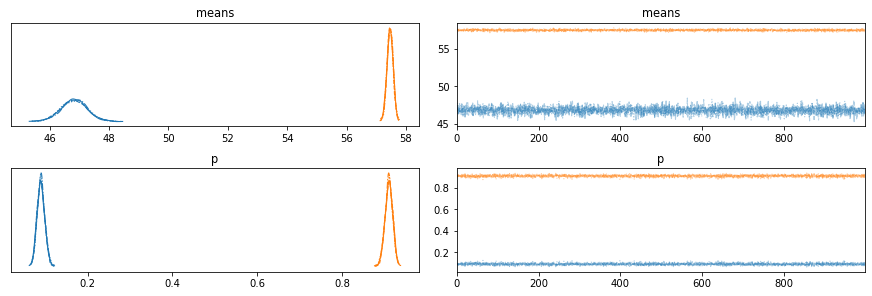

In [6]:
varnames = ['means', 'p']
az.plot_trace(trace_mg, varnames)

In [7]:
# seems like they "fixed" this..?
az.summary(trace_mg, varnames)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
means[0]  46.828  0.443  45.974   47.656      0.007    0.005    3667.0   
means[1]  57.463  0.101  57.277   57.655      0.002    0.001    3776.0   
p[0]       0.090  0.009   0.073    0.108      0.000    0.000    3427.0   
p[1]       0.910  0.009   0.892    0.927      0.000    0.000    3427.0   

          ess_tail  r_hat  
means[0]    3137.0    1.0  
means[1]    3268.0    1.0  
p[0]        2981.0    1.0  
p[1]        2981.0    1.0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

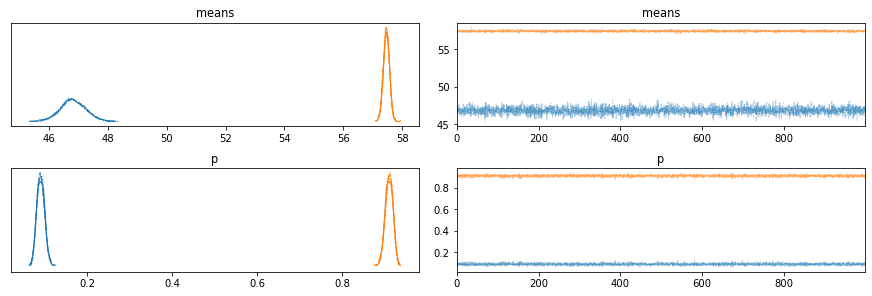

In [4]:
clusters = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=np.array([.9, 1]) * cs_exp.mean(),
                      sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    order_means = pm.Potential('order_means',tt.switch(means[1]-means[0] < 0,
                                                      -np.inf, 0))
    y = pm.NormalMixture('y', w = p, mu = means, sd = sd, observed = cs_exp)
    trace_mpg = pm.sample(1000)
    
varnames = ['means', 'p']
az.plot_trace(trace_mpg, varnames)
    

In [9]:
# again, this is great - but it does seem like they fixed it..
az.summary(trace_mpg)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
means[0]  46.835  0.436  46.011   47.629      0.007    0.005    3519.0   
means[1]  57.464  0.099  57.271   57.637      0.001    0.001    4660.0   
p[0]       0.091  0.009   0.075    0.108      0.000    0.000    3364.0   
p[1]       0.909  0.009   0.892    0.925      0.000    0.000    3364.0   
sd         3.652  0.074   3.513    3.789      0.001    0.001    4788.0   

          ess_tail  r_hat  
means[0]    3151.0    1.0  
means[1]    3244.0    1.0  
p[0]        3215.0    1.0  
p[1]        3215.0    1.0  
sd          3242.0    1.0

In [10]:
# p_min = pm.Potential('p_min', tt.switch(tt.min(p) < min_p, -np.inf, 0))
# above ensurs that each "class" gets at least one observation attached..
# set min_p to some low value (e.g. 0.1, 0.01).

In [11]:
# alpha for Dirichlet in [4, 10] is good baseline. (higher values, more informative prior). 

# Choosing K

In [12]:
# also takes a long time..
clusters = [3, 4, 5, 6]
models = []
traces = []

for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a = np.ones(cluster))
        means = pm.Normal('means', 
                         mu = np.linspace(cs_exp.min(), cs_exp.max(),
                                         cluster),
                         sd = 10, shape = cluster,
                         transform = pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd = 10)
        y = pm.NormalMixture('y', w = p, mu = means, sd = sd, observed = cs_exp)
        
        trace = pm.sample(1000, tune = 2000)
        traces.append(trace)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 165 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 217 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 150 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 268 seconds.
The acceptance probability does not match the target. It is 0.9251723253010167, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837995979337329, but should be close to 0.8. Try to increase the number of tuning steps.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7134676770377782, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
from scipy import stats

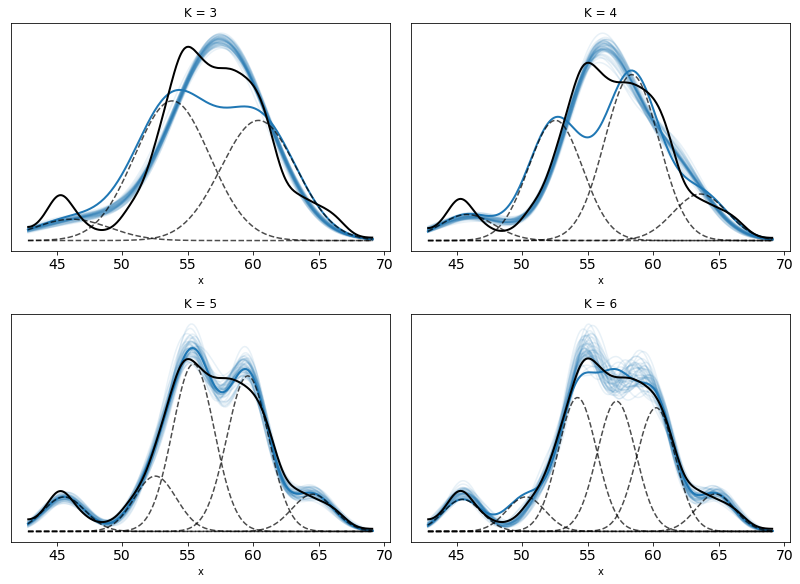

In [14]:
# crazy plot (very cool). 
_, ax = plt.subplots(2, 2, figsize = (11, 8), constrained_layout = True)

ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)

for idx, trace_x in enumerate(traces):
    x_ = np.array([x] * clusters[idx]).T 
    
    for i in range(50): 
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x['means'][i_]
        p_y = trace_x['p'][i_]
        sd = trace_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', alpha = 0.1)
        
    means_y = trace_x['means'].mean(0)
    p_y = trace_x['p'].mean(0)
    sd = trace_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', lw = 2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, 'k--', alpha = 0.7)
    az.plot_kde(cs_exp, plot_kwargs = {'linewidth':2,
                                      'color':'k'},
                ax = ax[idx])
    
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


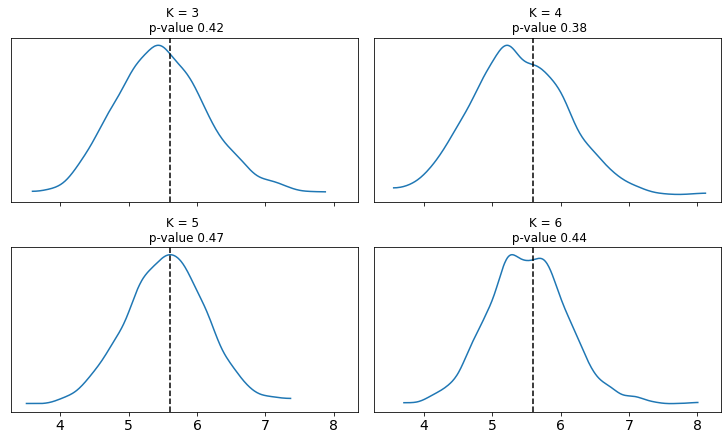

In [15]:
# the values I get are pretty different.
ppc_mm = [pm.sample_posterior_predictive(traces[i], 1000, models[i]) for i in range(4)]
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = np.ravel(ax)

def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

T_obs = iqr(cs_exp)

for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])

In [16]:
# which model is best acc. to IC?
# again, crazy values & it does not really correspond to the above.
# also weight should not ~1 for the best, but rather something like ~.95 (at most). 
# there is a -2 multiplier basically from the variance.. 
# just don't understand why the weight is so affected...
comp = az.compare(dict(zip(clusters, traces)), method = 'stacking', 
                  ic = "waic") #stacking rather. 
comp

C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank         waic     p_waic     d_waic        weight         se       dse  \
6     0 -5126.515523  12.683661   0.000000  1.000000e+00  30.795411  0.000000   
5     1 -5129.274236   9.943696   2.758713  0.000000e+00  30.777340  1.766043   
4     2 -5155.823342  19.980908  29.307819  0.000000e+00  31.348532  4.925596   
3     3 -5192.955616  15.139850  66.440093  1.736424e-10  32.172417  9.566060   

   warning waic_scale  
6    False        log  
5    False        log  
4    False        log  
3    False        log

KeyError: 0

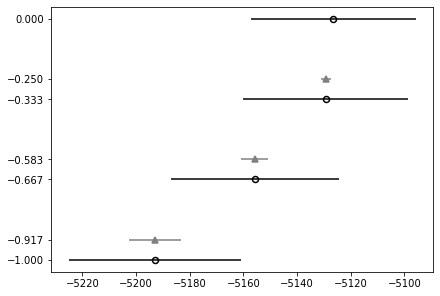

In [17]:
# some error here..?
az.plot_compare(comp)

# Mixture models & clustering

# Non-finite mixture models

# Dirichlet process

In [6]:
from scipy import stats

In [4]:

def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP

    Parameters
    ----------
    α : float concentration parameter
    H : scipy distribution Base distribution
    K : int. number of components

    Returns
    -------
    locs : array locations
    w : array probabilities
    """

    βs = stats.beta.rvs(1, α, size=K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    locs = H.rvs(size=K)
    return locs, w

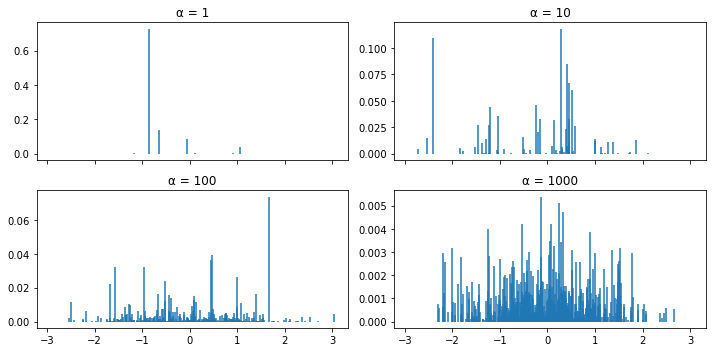

In [7]:
# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)

for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0')
    ax[idx].set_title('α = {}'.format(α))
    
plt.tight_layout()

In [ ]:
α = 10
H = stats.norm
K = 5
x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)
dist = stats.laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])

In [ ]:
N = cs_exp.shape[0]
K = 20

def stick_breaking(α):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [ ]:
# gamma as concentration parameter.
# small thing to tweak here.
with pm.Model() as model:
    α = pm.Gamma('α', 1., 1.)
    w = pm.Deterministic('w', stick_breaking(α))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=K)
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp.values)
    trace = pm.sample(1000, tune=2000, target_accept = 0.9) #changed this..?

In [ ]:
# should be many 
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, trace['w'].mean(0), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')

# E1
Generate synthetic from a mixture of three Gaussians. Check the accompanying
Jupyter Notebook for this chapter for an example on how to do this. Fit a finite
Gaussian mixture model with 2, 3, or 4 components.

In [3]:
# three random distributions
G1 = np.random.normal(loc = 2, scale = 4, size = 100)
G2 = np.random.normal(loc = 0, scale = 1, size = 50)
G3 = np.random.normal(loc = 1.5, scale = 7, size = 120)

In [25]:
# put them together
X = np.concatenate([G1, G2, G3])

In [26]:
# finite Gaussian model 
# also takes a long time..
clusters = [2, 3, 4]
modelsE1 = []
tracesE1 = []

for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a = np.ones(cluster))
        means = pm.Normal('means', 
                         mu = np.linspace(X.min(), X.max(), cluster),
                         sd = 10, shape = cluster,
                         transform = pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd = 10)
        y = pm.NormalMixture('y', w = p, mu = means, sd = sd, observed = X)
        
        trace = pm.sample(1000, tune = 2000)
        tracesE1.append(trace)
        modelsE1.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 44 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6608558587828371, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6868253673313818, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.666806662710618, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5031088829321467, but should be close to 0.

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 47 seconds.
The acceptance probability does not match the target. It is 0.916625139011007, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 79 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6877775943616072, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

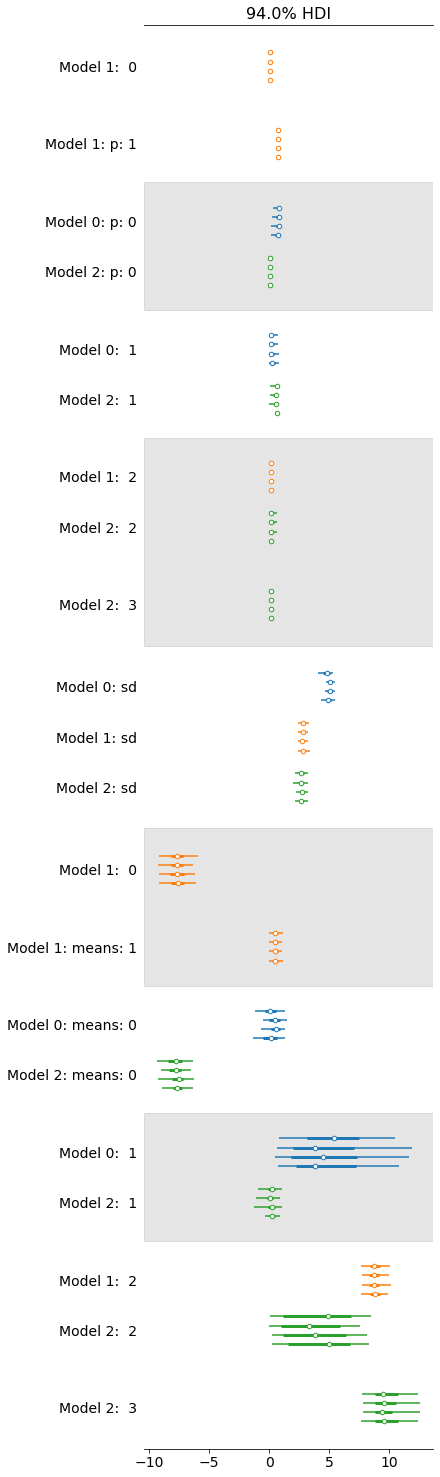

In [27]:
# How does it look (first glance)
az.plot_forest(tracesE1) # a bit confusing

array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

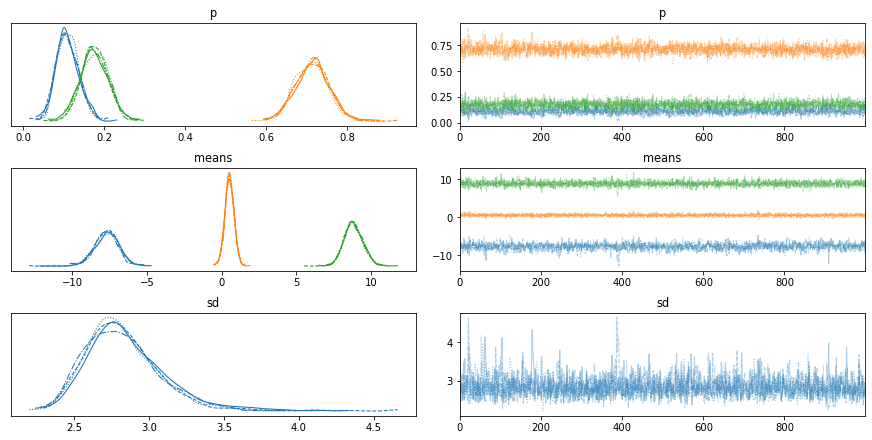

In [31]:
# number 1 (the correct number of distributions looks best).
# however, these means are crazy --> none of them should be negative..?
az.plot_trace(tracesE1[1])

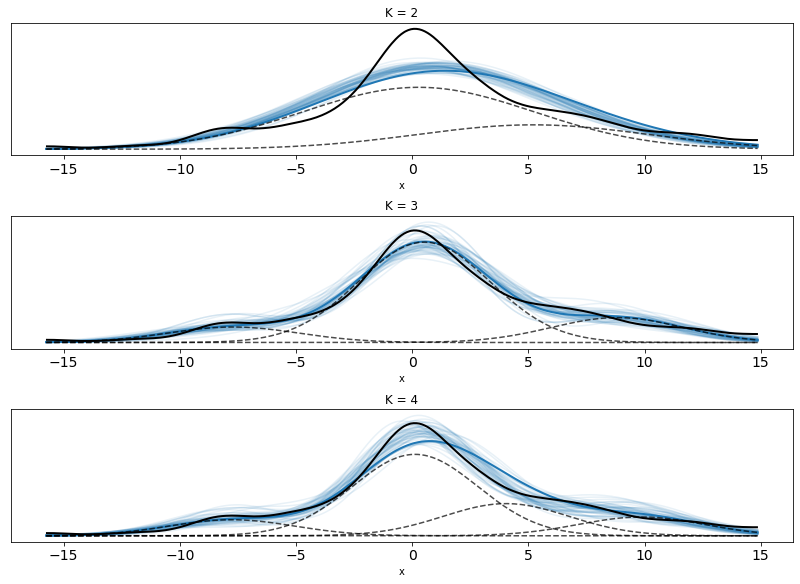

In [33]:
# Very cool. 
# Just means that I don't really know how to read the forest output..
_, ax = plt.subplots(3, 1, figsize = (11, 8), constrained_layout = True)

ax = np.ravel(ax)
x = np.linspace(X.min(), X.max(), 200)

for idx, trace_x in enumerate(tracesE1):
    x_ = np.array([x] * clusters[idx]).T 
    
    for i in range(50): 
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x['means'][i_]
        p_y = trace_x['p'][i_]
        sd = trace_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', alpha = 0.1)
        
    means_y = trace_x['means'].mean(0)
    p_y = trace_x['p'].mean(0)
    sd = trace_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', lw = 2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, 'k--', alpha = 0.7)
    az.plot_kde(X, plot_kwargs = {'linewidth':2,
                                      'color':'k'},
                ax = ax[idx])
    
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

# E2
Use WAIC and LOO to compare the results from exercise 1.

In [39]:
# first WAIC: 
WAIC_BB = az.compare({"2G": tracesE1[0],
                  "3G": tracesE1[1],
                  "4G": tracesE1[2]},
                 ic = "waic",
                 method = "BB-pseudo-BMA")
WAIC_BB

C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank        waic    p_waic    d_waic    weight         se       dse  \
3G     0 -820.411433  6.692371  0.000000  0.532353  14.279798  0.000000   
4G     1 -820.684771  7.728196  0.273338  0.431035  12.709427  0.809945   
2G     2 -828.451716  2.656495  8.040283  0.036612  13.998254  4.280418   

    warning waic_scale  
3G     True        log  
4G     True        log  
2G    False        log

In [41]:
# then loo
LOO_BB = az.compare({"2G": tracesE1[0],
                  "3G": tracesE1[1],
                  "4G": tracesE1[2]},
                 method = "BB-pseudo-BMA")
LOO_BB

C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank         loo     p_loo    d_loo    weight         se       dse  \
3G     0 -820.405341  6.686279  0.00000  0.561148  14.011517  0.000000   
4G     1 -820.794701  7.838127  0.38936  0.409358  12.675910  0.903165   
2G     2 -828.465921  2.670699  8.06058  0.029494  13.697430  4.278113   

    warning loo_scale  
3G    False       log  
4G    False       log  
2G    False       log

<AxesSubplot:xlabel='Log'>

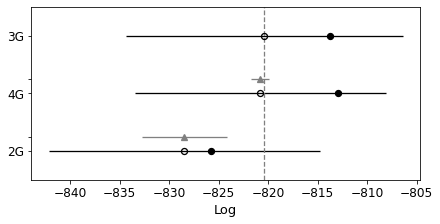

In [42]:
az.plot_compare(LOO_BB)

Looks good. 
The model with 3 Gaussians should be best, and 
is indeed best, so that is nice. 

# E3
Read and run the following examples about mixture models from the PyMC3
documentation: https://docs.pymc.io/nb_examples/

* https://docs.pymc.io/notebooks/marginalized_gaussian_mixture_model.html
* https://docs.pymc.io/notebooks/dependent_density_regression.html
* https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html


In [43]:
# first one: https://docs.pymc.io/notebooks/marginalized_gaussian_mixture_model.html

In [44]:
import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns

from matplotlib import pyplot as plt

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.1


In [45]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [46]:
# better way of simulating (more scalable at least)
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0.0, 2.0, 5.0])
SIGMA = np.array([0.5, 0.5, 1.0])

In [47]:
component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

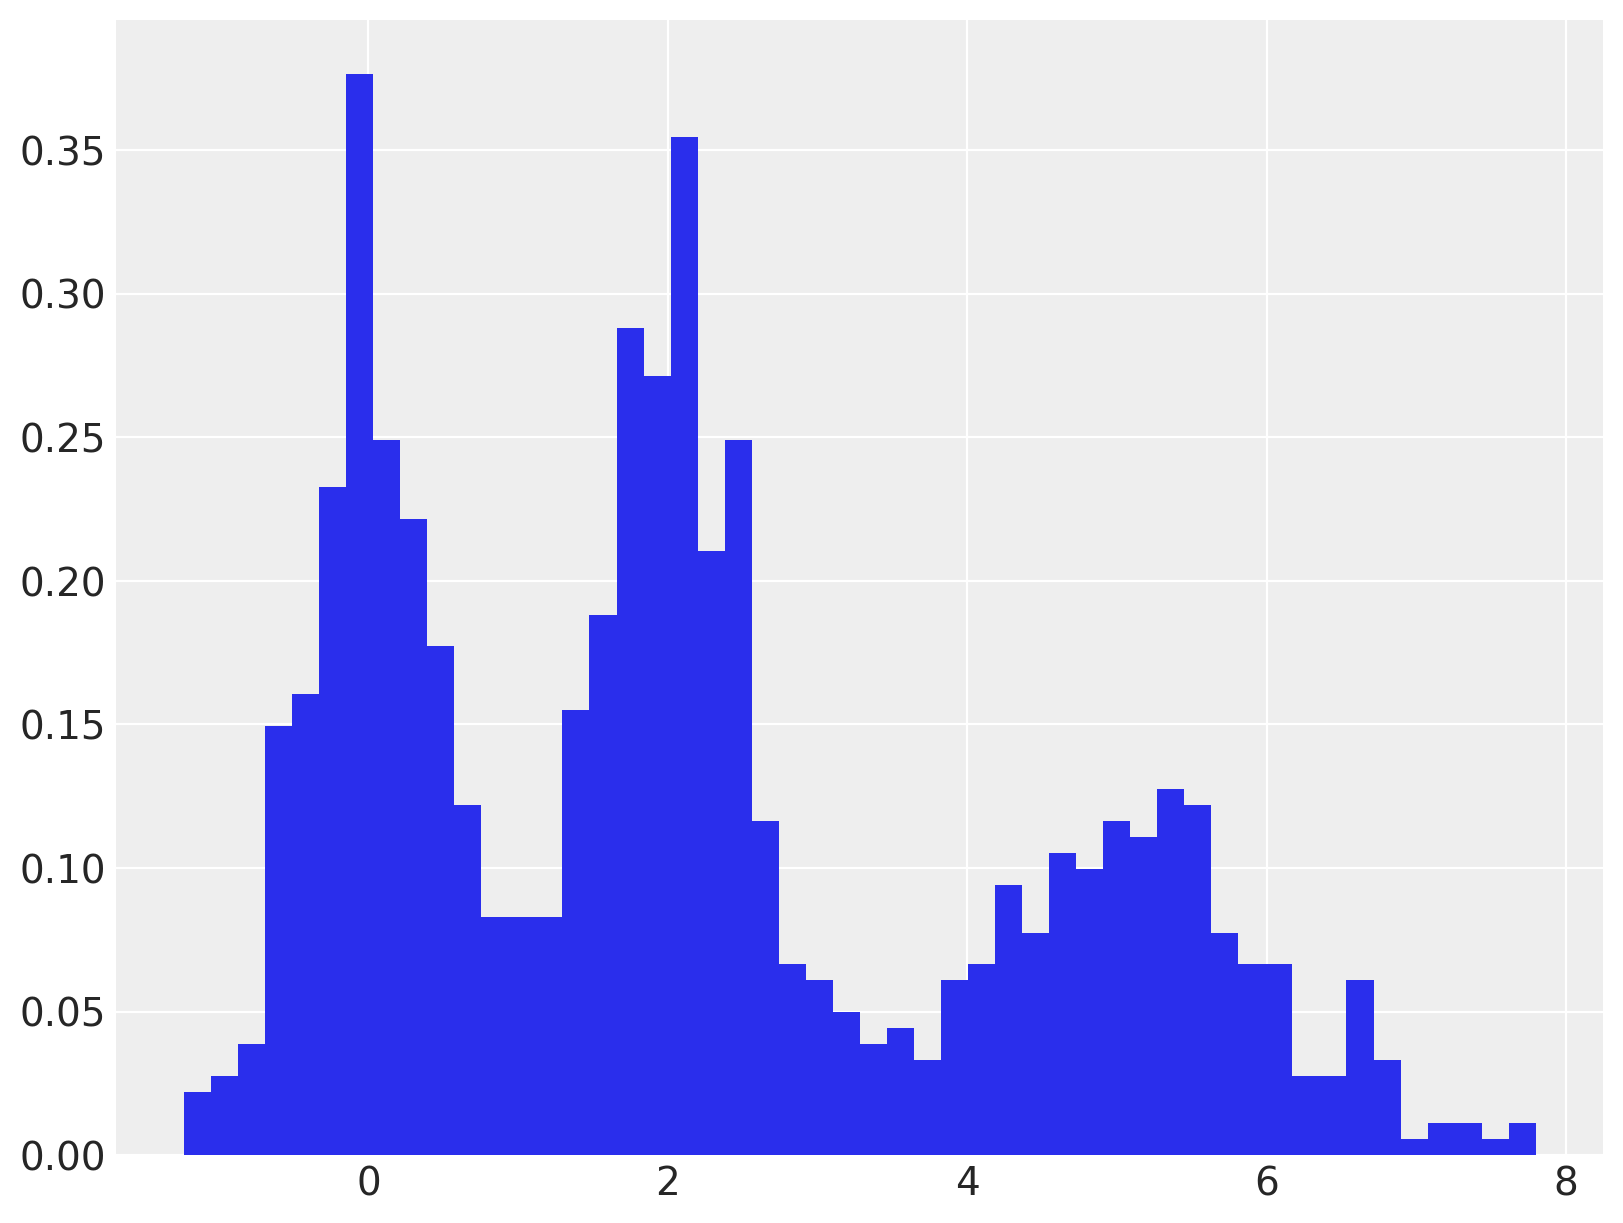

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=50, density=True, lw=0);

In [52]:
with pm.Model() as model:
    w = pm.Dirichlet("w", np.ones_like(W))

    mu = pm.Normal("mu", 0.0, 10.0, shape=W.size)
    tau = pm.Gamma("tau", 1.0, 1.0, shape=W.size)

    x_obs = pm.NormalMixture("x_obs", w, mu, tau=tau, observed=x)

In [55]:
with model:
    trace = pm.sample(2000, n_init=10000, tune=1000)

    # sample posterior predictive samples
    ppc_trace = pm.sample_posterior_predictive(trace, var_names=["x_obs"])

    # Get an arviz inference object
    idata_pymc3 = az.from_pymc3(trace, posterior_predictive=ppc_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, w]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


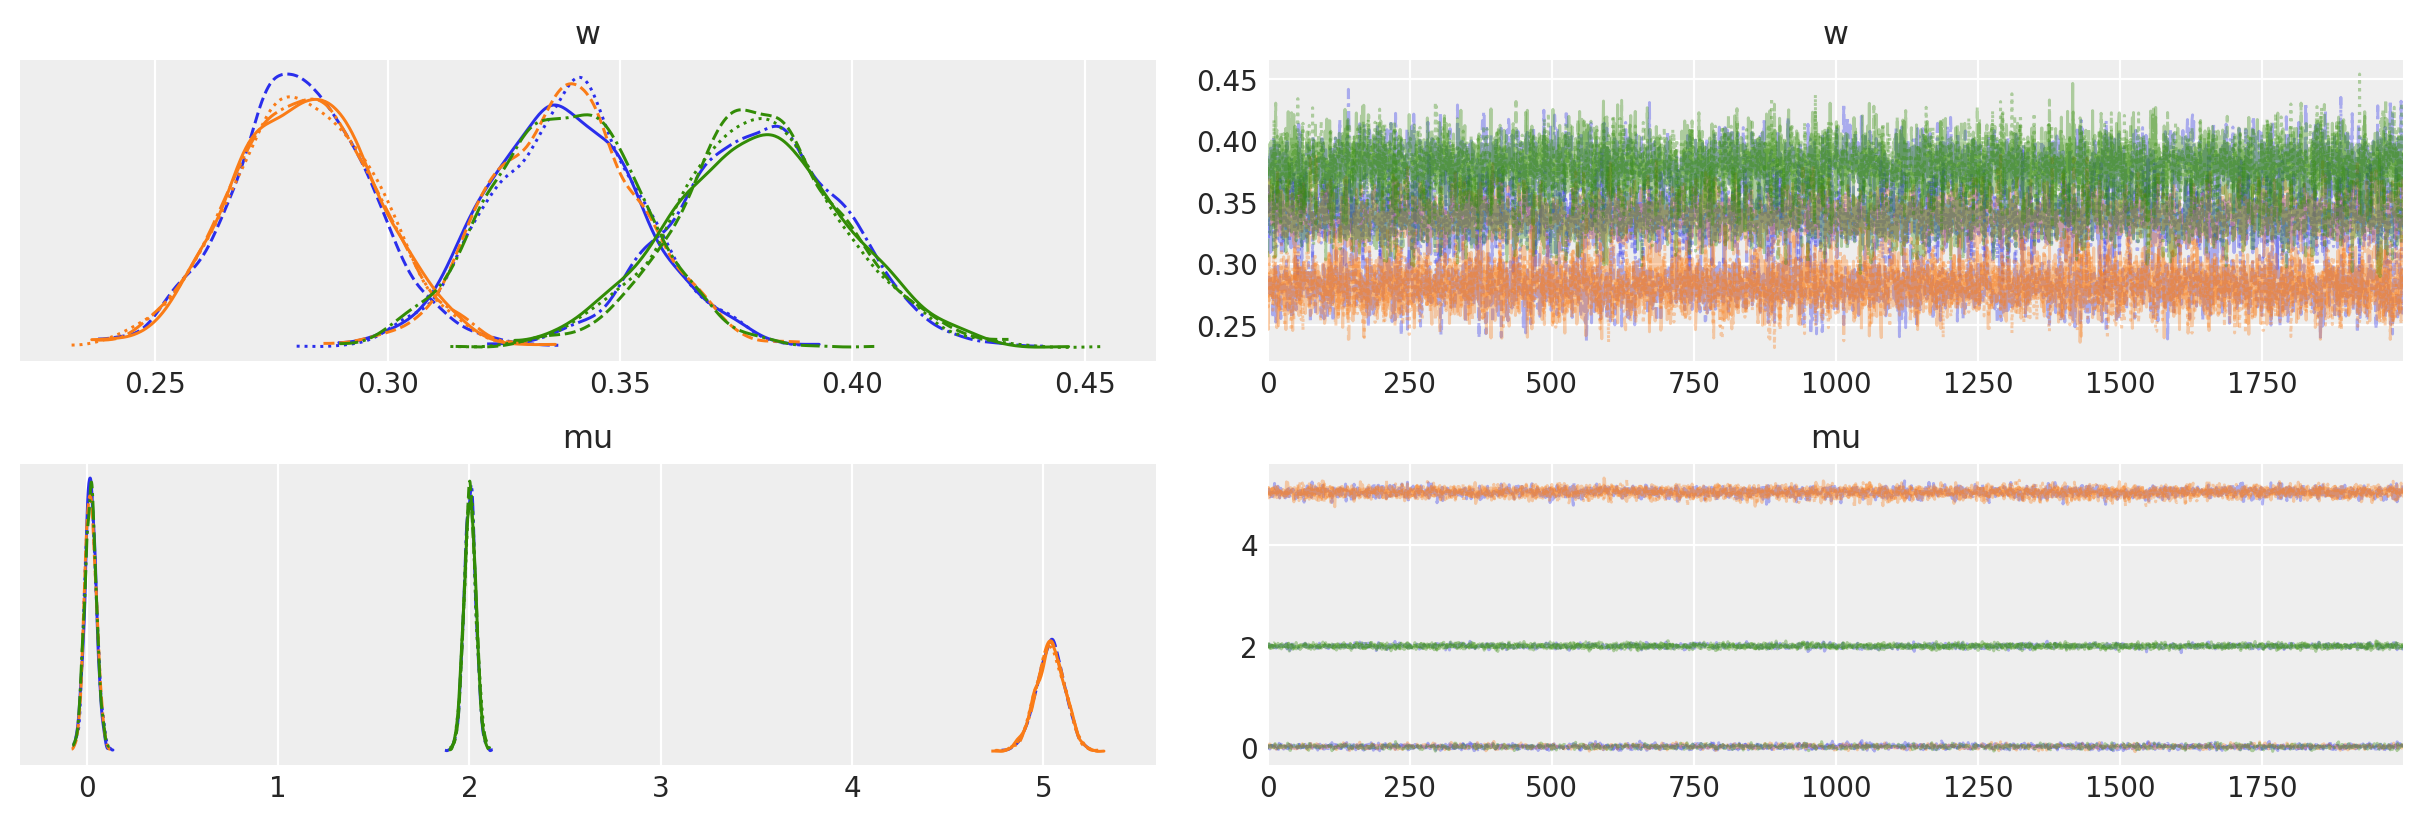

In [56]:
# here we actually see the non-specificity issue (or what it was called), right?
# they made the output more intuitive.. nice. 
az.plot_trace(idata_pymc3, var_names=["w", "mu"]);

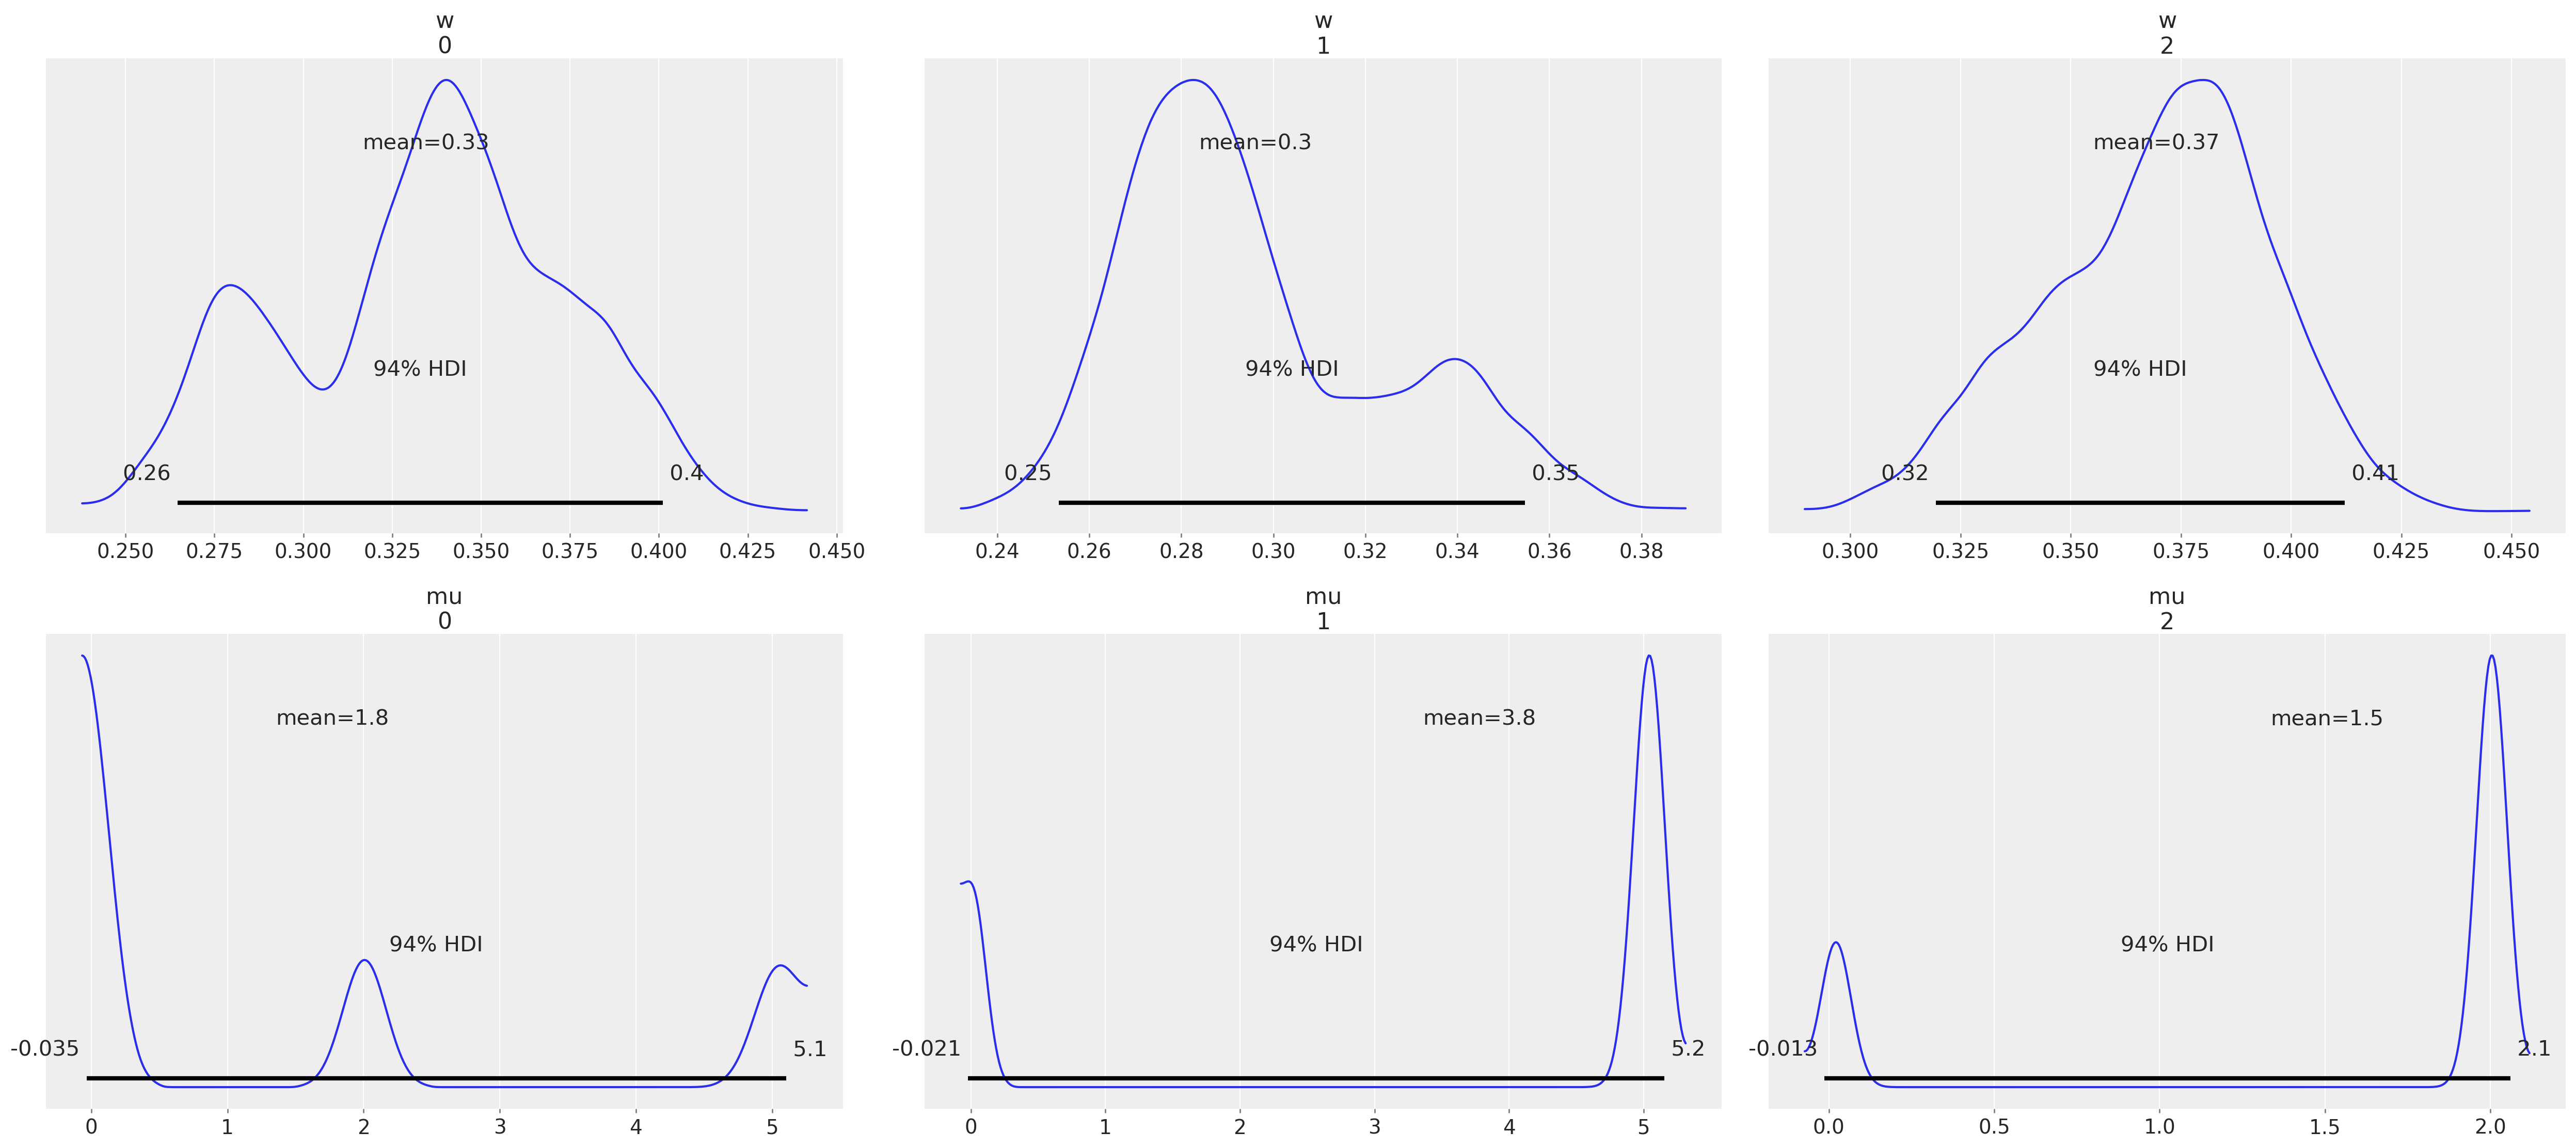

In [59]:
az.plot_posterior(idata_pymc3, var_names=["w", "mu"]);

<AxesSubplot:xlabel='x_obs'>

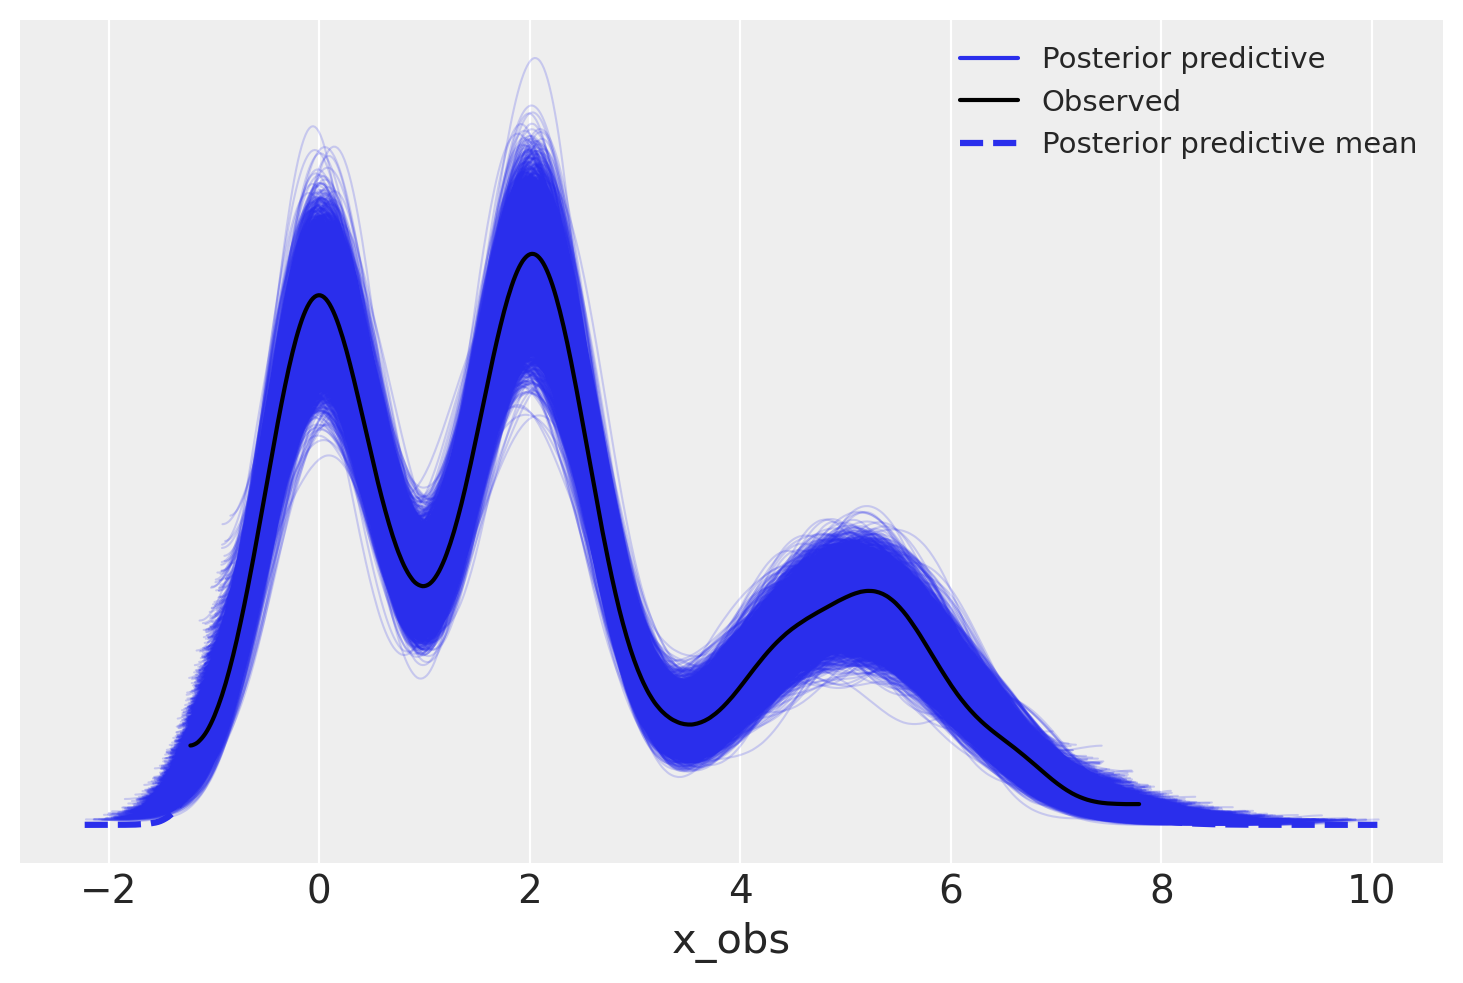

In [58]:
az.plot_ppc(idata_pymc3)

In [60]:
# second one: https://docs.pymc.io/notebooks/dependent_density_regression.html

In [61]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from IPython.display import HTML
from matplotlib import animation as ani
from matplotlib import pyplot as plt
from theano import shared
from theano import tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.1


In [62]:
%config InlineBackend.figure_format = 'retina'
plt.rc("animation", writer="ffmpeg")
blue, *_ = sns.color_palette()
az.style.use("arviz-darkgrid")
SEED = 972915  # from random.org; for reproducibility
np.random.seed(SEED)

In [66]:
# this does not work.
# seems like it would take some work to fix..
DATA_URI = "http://www.stat.cmu.edu/~larry/all-of-nonpar/=data/lidar.dat"


def standardize(x):
    return (x - x.mean()) / x.std()


#df = pd.read_csv(DATA_URI, sep=" *", engine="python").assign(std_range=lambda df: standardize(df.range), std_logratio=lambda df: standardize(df.logratio))
df = pd.read_csv(DATA_URI, sep = " *", engine = "python")

In [69]:
# example 3: https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html

In [70]:
%env THEANO_FLAGS=device=cpu,floatX=float32

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

from pymc3 import (
    NUTS,
    DensityDist,
    Dirichlet,
    Metropolis,
    MvNormal,
    Normal,
    Slice,
    find_MAP,
    sample,
)
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

print(f"Running on PyMC3 v{pm.__version__}")

env: THEANO_FLAGS=device=cpu,floatX=float32
Running on PyMC3 v3.11.1


In [71]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

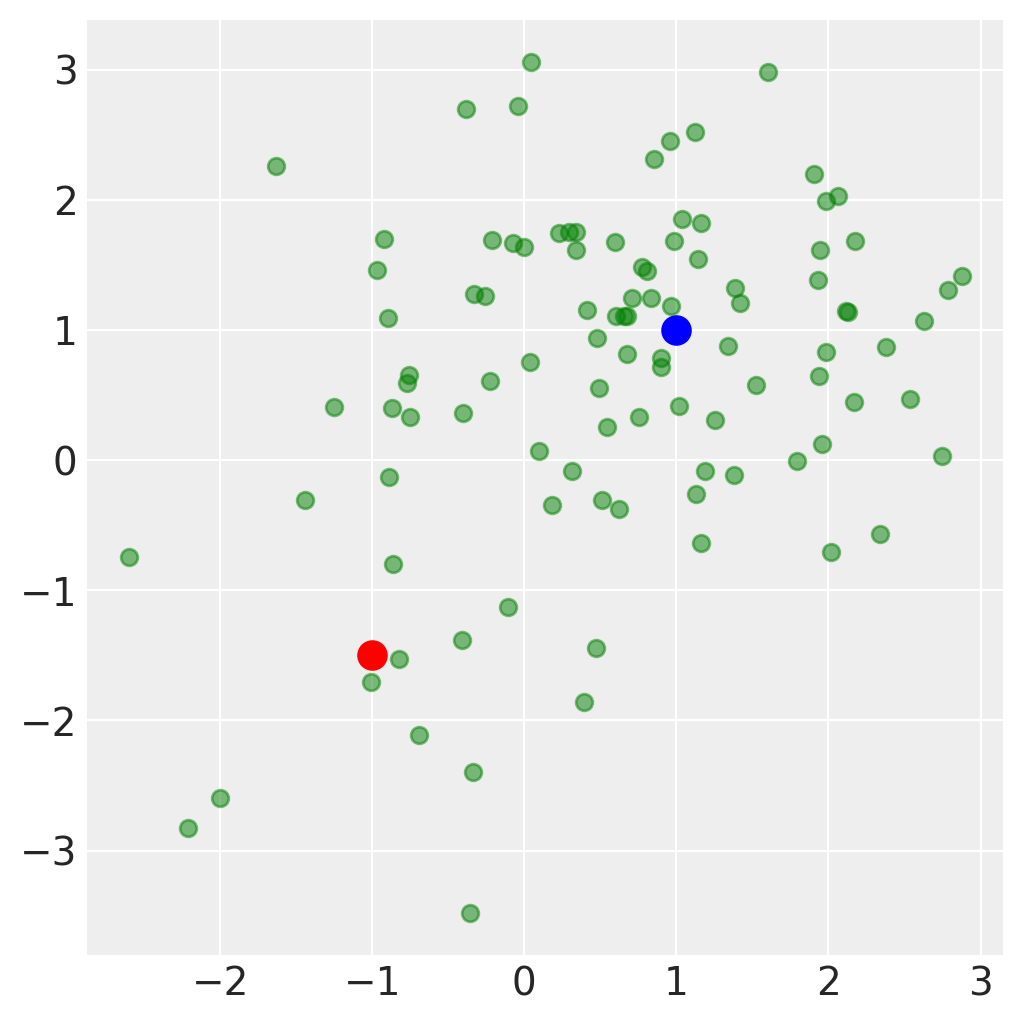

In [72]:
# create data
n_samples = 100
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1]])
ps = np.array([0.2, 0.8])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples) for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c="g", alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c="r", s=100)
plt.scatter(ms[1, 0], ms[1, 1], c="b", s=100);

In [73]:
from pymc3.math import logsumexp


# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * tt.log(2 * np.pi)
        + tt.log(1.0 / det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )


# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value) for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_


with pm.Model() as model:
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(2)), observed=data)

In [ ]:
# killed my kernel :( 
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]


In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c="g")
mu_0, mu_1 = trace["mu_0"], trace["mu_1"]
plt.scatter(mu_0[:, 0], mu_0[:, 1], c="r", s=10)
plt.scatter(mu_1[:, 0], mu_1[:, 1], c="b", s=10)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

# E4
Repeat exercise 1 using a Dirichlet process.

In [9]:
# three random distributions
G1 = np.random.normal(loc = 2, scale = 4, size = 100)
G2 = np.random.normal(loc = 0, scale = 1, size = 50)
G3 = np.random.normal(loc = 1.5, scale = 7, size = 120)

In [10]:
# put them together
X = np.concatenate([G1, G2, G3])

In [16]:
# stick breaking function
def stick_breaking(α):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [18]:
# just copied the code from earlier.
# do not understand the parameters and the strick_breaking well. 
# this does not work (starting values..)
models = []
traces = []
for K in [2, 3, 4]:
    with pm.Model() as model:
        α = pm.Gamma('α', 1., 1.)
        w = pm.Deterministic('w', stick_breaking(α))
        means = pm.Normal('means', mu = X.mean(), sd = 10, shape = K)
        sd = pm.HalfNormal('sd', sd=10, shape = K)
        obs = pm.NormalMixture('obs', w, means, sd = sd, observed = X)
        trace = pm.sample(1000, tune=2000, traget_accept = 0.9) #changed this..?

        models.append(model)
        traces.append(trace)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'α_log__': array(0.), 'β_logodds__': array([0., 0.]), 'means': array([1.38568032, 1.38568032]), 'sd_log__': array([2.07679374, 2.07679374])}

Initial evaluation results:
α_log__       -1.00
β_logodds__   -2.77
means         -6.44
sd_log__      -1.54
obs            -inf
Name: Log-probability of test_point, dtype: float64

# E5
Assuming for a moment that you do not know the correct species/labels for the
Iris dataset, use a mixture model to cluster the three iris species, using one
feature of your choice (like the length of the sepal).

In [29]:
import os
d = pd.read_csv("../data/iris.csv")
d.head(5)

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [31]:
# predictor
X = d["sepal_length"].values
X

array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
       4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
       5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
       5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
       6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
       6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
       6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
       6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3,
       6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5,
       7.7, 7.7, 6. , 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2,
       7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6. , 6.9, 6.7, 6.9, 5.8,
       6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9])

In [35]:
# using the model from task 1
# these models are also terrible
tracesE5 = []
modelsE5 = []
clusters = [2, 3, 4]
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a = np.ones(cluster))
        means = pm.Normal('means', 
                         mu = np.linspace(X.min(), X.max(), cluster),
                         sd = 5, shape = cluster,
                         transform = pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd = 5)
        y = pm.NormalMixture('y', w = p, mu = means, sd = sd, observed = X)
        
        trace = pm.sample(1000, tune = 4000)
        tracesE5.append(trace)
        modelsE5.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 60 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6322283317756394, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5790641507915565, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6888920491351044, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during samplin

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 72 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7118462643374135, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6748556761098894, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4320855797491703, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS 

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 98 seconds.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6312121558355057, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7206821968509737, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [46]:
# can we do model comparison?
loo = az.compare({"K = 2": tracesE5[0],
                  "K = 3": tracesE5[1],
                  "K = 4": tracesE5[2]},
                method = "BB-pseudo-BMA")
loo

C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank         loo     p_loo     d_loo    weight        se       dse  \
K = 4     0 -184.436752  4.305187  0.000000  0.460252  7.180659  0.000000   
K = 3     1 -184.782424  3.666480  0.345673  0.309835  6.977658  0.415726   
K = 2     2 -185.387073  2.000419  0.950322  0.229913  6.820148  1.150354   

       warning loo_scale  
K = 4    False       log  
K = 3    False       log  
K = 2    False       log

array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

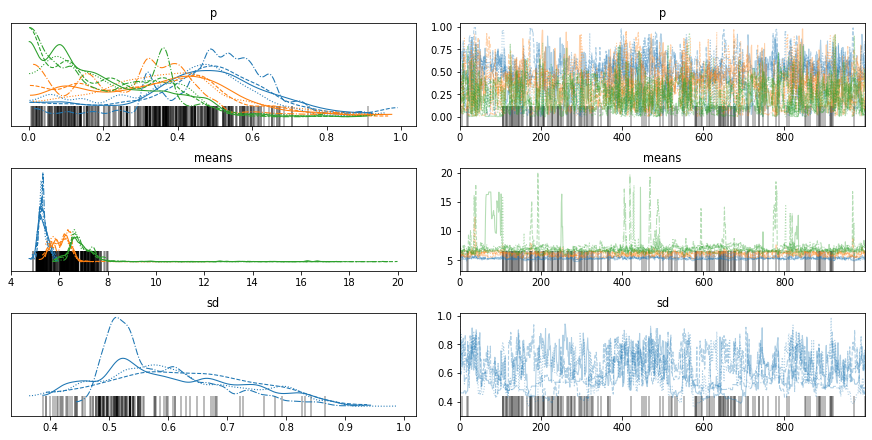

In [47]:
az.plot_trace(tracesE5[1])

In [49]:
import seaborn as sns

<AxesSubplot:xlabel='sepal_length', ylabel='Density'>

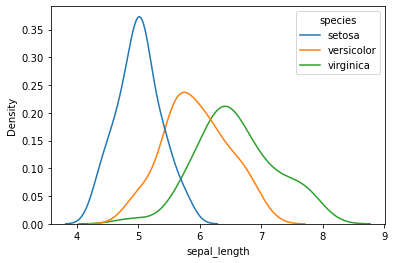

In [51]:
# sort of gets it right..
sns.kdeplot(data = d, x = "sepal_length", hue = "species")

# E6
Repeat exercise 5 but this time use two features.

In [53]:
X1 = d["sepal_length"].values
X2 = d["sepal_width"].values

In [56]:
X = np.stack((X1, X2), axis = -1)

In [ ]:
# using the model from task 1
# these models are also terrible
# not sure how to actually do this..
clusters = 3
for cluster in clusters:
    with pm.Model() as mE6:
        p = pm.Dirichlet('p', a = np.ones(cluster))
        means = pm.Normal('means', 
                         mu = np.linspace(X.min(), X.max(), cluster),
                         sd = 5, shape = cluster,
                         transform = pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd = 5)
        y = pm.NormalMixture('y', w = p, mu = means, sd = sd, observed = X)
        
        tE6 = pm.sample(1000, tune = 4000)